In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 自分自身が過去に考えた回答も学習する

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#model_name="ahxt/LiteLlama-460M-1T"
#model_name = "PY007/TinyLlama-1.1B-Chat-v0.3"

#model_name = 'openlm-research/open_llama_3b_v2'
#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.
Loading checkpoint shards: 100%|██████████| 3/3 [00:29<00:00,  9.86s/it]


In [5]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [6]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [7]:
#240112llama2_active_learning.ipynb で生成したデータを追加する
#train dataについて､問題のみから理由と回答を生成させ､精度が良かったデータセット
import glob
import json
json_path_glob="dataset/240112llamareasoning/*.json"

self_learning_data_list=[]

for path in glob.glob(json_path_glob):
    with open(path,"r") as f:
        d=json.load(f)
    #24/1/16追記
    gen_reason=d["Test (Predicted reason)"]
    for tag in [
        "##Prediction","#Prediction"
                ]:
        if gen_reason.find(tag)>0:
            gen_reason=gen_reason.split(tag)[0]
    gen_reason=gen_reason.strip()
    if len(gen_reason)<10:
        continue
    print(gen_reason,"\n")
    d["Reason"]=gen_reason

    d["Prediction(integer)"]=d["Test (Predicted value)"]
    self_learning_data_list.append(d)

s_df=pd.DataFrame(self_learning_data_list)

n_unique_compounds=len(set(s_df["name"]))
print(f"unique: compounds: {n_unique_compounds}. records: {s_df.shape[0]}")

s_df=s_df.drop(["model_name","Test (Predicted reason)","Test (Predicted value)"],axis=1)
df=pd.concat([df,s_df])
df

The basic unit for comparison is indole, which has a melting point of 55.6°C. The addition of a methyl group typically increases the melting point due to an increase in molecular weight and van der Waals interactions, estimated at +5°C. The acetyl group is an ester functional group, which can increase the melting point due to dipole-dipole interactions and potential hydrogen bonding, estimated at +10°C. However, the presence of the methyl group may slightly reduce the melting point due to steric hindrance, estimated at -2°C. 

The target compound, 2-methyl-4-nitrobutane, has a butane backbone with a methyl group and a nitro group. The butane base has a melting point around -138 degrees Celsius. The methyl group, being a small alkyl chain, typically increases the melting point by a small amount due to increased van der Waals interactions, estimated at +5 degrees. The nitro group is a strong electron-withdrawing group that can engage in dipole-dipole interactions and can also participate

,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0
2,"4-methoxy-1,8,8-trimethylbicyclo[3.2.1]oct-3-e...",O=C1C=C(OC)C2CCC1(C)C2(C)C,2032094,http://dx.doi.org/10.1021/ci0500132,Karthikeyan M.; Glen R.C.; Bender A. General m...,"The target compound, 4-methoxy-1,8,8-trimethyl...",55.0,51.0,4.0
3,3-chloro-dimethyl parathion,O=[N+]([O-])c1ccc(cc1Cl)OP(=S)(OC)OC,9944,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,The melting point of a compound is influenced ...,21.0,22.0,1.0
4,"3,4-dimethoxy-5-hydroxybenzoic acid",O=C(O)c1cc(O)c(OC)c(OC)c1,67282,http://dx.doi.org/10.1021/ci0500132,Karthikeyan M.; Glen R.C.; Bender A. General m...,"Starting base unit is benzoic acid, which has ...",195.0,192.0,3.0
...,...,...,...,...,...,...,...,...,...
2239,6-methylisoquinoline,Cc1ccc2cnccc2c1,556289,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"- Basic unit, benzene, has a melting point of ...",85.5,105.0,0.5
2240,4-nitrophenyl bromoacetate,c1cc(ccc1[N+](=O)[O-])OC(=O)CBr,90953,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08000,Alfa Aesar,The compound 4-nitrophenyl bromoacetate has se...,86.0,105.0,4.5
2241,"(2E)-1-(2,4-dinitrophenyl)-2-(4-methoxybicyclo...",O=[N+]([O-])c1ccc(NN=C2Cc3ccc(OC)cc32)c([N+](=...,7855536,http://dx.doi.org/10.1021/ci0500132,Karthikeyan M.; Glen R.C.; Bender A. General m...,The compound in question is a complex molecule...,221.0,205.0,8.0
2242,dfdd,Fc1ccc(cc1)C(=C(/Cl)Cl)c2ccc(F)cc2,13597790,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"- Basic unit, benzene has a melting point of 5...",77.0,75.0,8.0


In [8]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [9]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:  42%|████▏     | 1000/2356 [00:00<00:00, 8709.75 examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8494.33 examples/s]


In [10]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [11]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.688600
200,1.267200
300,1.160300
400,1.091700
500,1.090100
600,1.055700
700,1.027700
800,1.041000
900,1.029500
1000,1.013900


In [ ]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
model.save_pretrained(f"./outputs/13b_ft_with_self_prediction_0115")

In [ ]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [ ]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/3b_ft_merge_3epoch")

# llama2による物性予測

In [12]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [ ]:
model_name="./outputs/13b_ft_merge_3epoch"
model=AutoModelForCausalLM.from_pretrained(model_name,device_map=device_map,
                                              torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                           )


Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


In [13]:
import json
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
              (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
              (v_proj): Linear(
                in_features=5120, out_features=5120, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lor

In [ ]:
from datetime import datetime
import json

#色々と条件を変えながら､訓練データで予測(自習)していく

#予測時のハイパラ
n_max_trials=4  # 値を返さなかったときの再試行の最大数
prediction_results={}


res_list=[]
for train_id in tqdm(range(10**5)):
    clear_output()
    gc.collect()
    torch.cuda.empty_cache()
    for _ in range(n_max_trials):
        try:

            n_prompt_examples=random.randint(0,2) #何件の例題をprompt tuningで出すか
            prompt=generate_question_prompt(dataset,train_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            try:
                value=float(value)
            except:
                continue

            record=copy.deepcopy(dataset[train_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            record["model_name"]=model_name

            err=abs(record["mpC"]-float(value))
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],"err: ",err)

            
            if err<20:
                current_datetime = datetime.now()

                save_path=f"dataset/240112llamareasoning/{current_datetime}.json"
                save_path.replace("-","").replace(":","")
                with open(save_path,"w") as f:
                    json.dump(record,f,indent=4)

                break

----


The compound tri(p-tolyl)phosphine consists of three p-tolyl groups and a phosphine group. The basic unit, benzene, has a melting point of 5.5°C. The p-tolyl groups are aromatic rings which increase the melting point due to increased molecular weight and van der Waals forces. Each p-tolyl group could add approximately +20°C to the melting point. The phosphine group is a highly electronegative group that can form strong intermolecular bonds, which would significantly increase the melting point. We can estimate an addition of about +100°C for the phosphine group.
##Prediction: 235.0


#Prediction
actual:  145.0 predicted:  235.0 err:  90.0
----


##Prediction: 120.0

##Reason
actual:  145.0 predicted:  120.0 err:  25.0
----


The target compound, tri(p-tolyl)phosphine, is a complex molecule with multiple functional groups and structural features that influence its melting point. The base structure can be considered as phosphine, which has a melting point of approximately -120°C du

34.0

# モデルによる物性値の予測

In [14]:
#予測時のハイパラ
n_prompt_examples=0 #何件の例題をprompt tuningで出すか:  例題に予測が引っ張られがちなので､0にしてみる
n_max_trials=1  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            res_list.append(record)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:14<11:44, 14.37s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The amino group (-NH2) is expected to increase the melting point due to the potential for hydrogen bonding, which can be estimated to add approximately +40°C. 
- The ester group (-COO-) typically increases the melting point due to the polar nature and potential for dipole-dipole interactions, which can be estimated to add around +20°C. 
- The tetramethylcyclopentyl group is a bulky substituent that can increase the melting point by providing more van der Waals interactions, estimated at +15°C. 
- The additional methyl group on the benzene ring is a small alkyl group that can slightly increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. 
- The cumulative effect of these functional groups on the benzene base structure should be considered.
##Prediction: 85.0
##Reason
actual:  74.0 predicted:  85.0
promlem 2 / 50


  4%|▍         | 2/50 [00:22<08:30, 10.63s/it]

----


- Basic unit, quinoxaline has a melting point of around 220°C. 
- Chloro substituents: Each chloro group is electron-withdrawing and increases intermolecular forces due to its polarity, which typically raises the melting point. However, the effect of chloro groups on aromatic compounds can be less pronounced than on aliphatic compounds due to the stabilization of the aromatic ring. Each chloro group might raise the melting point by approximately 20°C. 
- The presence of two chloro groups would therefore increase the melting point by approximately 40°C.
##Prediction: 260.0
##Reason
actual:  152.0 predicted:  260.0
promlem 3 / 50


  6%|▌         | 3/50 [00:32<08:06, 10.36s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Chloromethyl groups: Each chloromethyl group is electron-withdrawing and increases intermolecular forces due to its polarity, which typically raises the melting point. However, the introduction of chlorine atoms also increases the molecular weight and size, which can disrupt the crystal lattice and lower the melting point. The effect of chloromethyl groups is complex and depends on the molecular context. Assuming a moderate effect, we can estimate each chloromethyl group to raise the melting point by approximately 20°C. 
- The presence of two chloromethyl groups would therefore increase the melting point by approximately 40°C (20°C per group).
##Prediction: 45.0
##Reason
actual:  100.0 predicted:  45.0
promlem 4 / 50


  8%|▊         | 4/50 [00:44<08:27, 11.02s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of the conjugated double bond in the propenone structure increases the rigidity of the molecule, which typically raises the melting point. This effect can be estimated to add approximately +20°C. 
- The additional phenyl group adds to the molecular weight and the pi-pi interactions, which can further increase the melting point. This can be estimated to add around +30°C. 
- The carbonyl group (C=O) is polar and can engage in dipole-dipole interactions, which can raise the melting point. This effect can be estimated to add around +10°C. 
- The overall molecular structure is complex and the effects of the functional groups are not strictly additive, so the actual melting point may be different from the sum of these contributions.
##Prediction: 65.0
##Reason
actual:  56.5 predicted:  65.0
promlem 5 / 50


 10%|█         | 5/50 [00:58<09:10, 12.24s/it]

----


- Basic unit, ethane has a melting point of -172°C. 
- Hydroxyl group (-OH): +40°C (introduces hydrogen bonding which significantly increases the melting point). 
- Disulfide bond (-S-S-): +100°C (the sulfur atoms in the disulfide bond are capable of strong dipole-dipole interactions and can form additional intermolecular bonds, leading to a higher melting point). 
- Ethyl group: +5°C (the addition of an ethyl group increases the molecular weight and size, which can slightly increase the melting point). 
- The overall molecule is polar and has a significant amount of mass, which also contributes to an increase in the melting point. 
- The presence of two sulfur atoms in the disulfide bond contributes to a higher melting point due to the increased molecular weight and the potential for additional intermolecular interactions. 
- The hydroxyl group and the disulfide bond are the primary contributors to the melting point increase.
##Prediction: 105.0
##Reason
actual:  26.0 predicted

 12%|█▏        | 6/50 [01:15<09:59, 13.64s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of two phenyl groups increases the melting point due to increased molecular weight and π-π interactions, estimated at +40°C per phenyl group. 
- The nicotinamide group is a rigid, planar structure that can engage in hydrogen bonding, which significantly raises the melting point; this effect is estimated at +100°C. 
- The ethyl group attached to the nicotinamide is a small alkyl chain that can increase the melting point due to increased molecular weight and van der Waals interactions, estimated at +5°C. 
- The overall molecular structure is complex and rigid, which can lead to a higher melting point due to the increased intermolecular forces, estimated at +20°C. 
- The presence of the amide group (C=O) can form hydrogen bonds, which can further increase the melting point, estimated at +10°C. 
- The cumulative effect of these functional groups is expected to significantly raise the melting point from the base valu

 14%|█▍        | 7/50 [01:32<10:41, 14.91s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Methoxy groups: Each methoxy group (-OCH3) is expected to increase the melting point due to the introduction of polarity and the ability to engage in dipole-dipole interactions. We can estimate this increase to be around +20°C per methoxy group. 
- Methyl group: The methyl group (-CH3) attached to the phenyl ring also increases the melting point due to an increase in molecular weight and van der Waals forces. This can be estimated to be around +5°C. 
- Ketone group: The presence of a ketone (C=O) can form hydrogen bonds, which typically increases the melting point. This effect can be estimated to be around +40°C. 
- Conjugation: The conjugation between the two phenyl rings can increase the melting point due to increased rigidity and planarity of the molecule. This effect can be estimated to be around +10°C. 
- Overall, the cumulative effect of these functional groups on the melting point is expected to be additive.
##Predict

 16%|█▌        | 8/50 [01:38<08:28, 12.12s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Propyl group: +20°C (due to increased molecular weight and van der Waals forces). 
- The propyl group is a small alkyl chain, which typically increases the melting point due to increased molecular weight and van der Waals forces. However, the effect of the propyl group on the melting point is not as significant as that of a larger alkyl group like a butyl or pentyl group.
##Prediction: 25.0
##Reason
actual:  -99.0 predicted:  25.0
promlem 9 / 50


 18%|█▊        | 9/50 [01:54<09:02, 13.23s/it]

----


- Basic unit, aniline (phenylamine) has a melting point of around 6 degrees Celsius. 
- The nitro group is an electron-withdrawing group and can increase the melting point due to its ability to form strong intermolecular forces such as hydrogen bonding and dipole-dipole interactions. This effect can be estimated to increase the melting point by approximately 80 degrees Celsius. 
- The acetamide group is also an electron-withdrawing group and can increase the melting point due to its ability to form hydrogen bonds and dipole-dipole interactions. This effect can be estimated to increase the melting point by approximately 40 degrees Celsius. 
- The overall molecule is more rigid and planar due to the presence of the phenyl ring and the amide linkage, which can increase the melting point by providing a more ordered structure. This effect can be estimated to increase the melting point by approximately 20 degrees Celsius. 
- The combined effects of these functional groups should lead 

 20%|██        | 10/50 [02:00<07:23, 11.09s/it]

----


- Basic unit, ethane has a melting point of -172°C. 
- Acetate ester functional group: +40°C (due to the polar carbonyl group which can form dipole-dipole interactions and has a moderate impact on the melting point). 
- Propyl group: +20°C (due to the increase in molecular weight and van der Waals forces). 
- The overall effect of these functional groups is an increase in the melting point compared to the basic unit.
##Prediction: -132.0
##Reason
actual:  -92.0 predicted:  -132.0
promlem 11 / 50


 22%|██▏       | 11/50 [02:16<08:03, 12.40s/it]

----


- Basic unit, anisole has a melting point of -6°C. 
- The presence of a nitro group generally increases the melting point due to its strong electron-withdrawing nature and the ability to form intermolecular hydrogen bonds, which can be estimated to increase the melting point by about +80°C. 
- The iodine substituent is a heavy halogen that increases the molecular weight and enhances van der Waals forces, which can be estimated to increase the melting point by about +20°C. 
- The hydroxyl group in anisole is capable of forming hydrogen bonds, which can further increase the melting point. However, since this effect is already accounted for in the basic unit, it is not included in the additional increments. 
- The presence of the methyl group (–CH3) attached to the phenyl ring in anisole does not significantly affect the melting point, so it is not considered in the estimation.

Combining these effects, the predicted melting point would be the sum of the adjustments made to the bas

 24%|██▍       | 12/50 [02:31<08:19, 13.15s/it]

----


- Basic unit, ethene (ethylene) has a melting point of -169.2°C. 
- Each additional methyl group generally increases the melting point due to an increase in molecular weight and van der Waals forces. For 2,2-dimethyl-3-hexene, we have two additional methyl groups. Each methyl group can be estimated to raise the melting point by about 20°C. 
- The (Z) configuration of the double bond can have a slight effect on the melting point due to the symmetry and packing efficiency of the molecules. This effect is generally small and can be estimated to be around 5°C. 
- The actual value of -10.0°C is lower than the predicted value, indicating that the effects of the methyl groups and the (Z) configuration are not as strong as initially estimated. The actual value suggests that the increase in molecular weight and van der Waals forces due to the methyl groups is not enough to overcome the destabilizing effect of the double bond, which tends to lower the melting point.
##Prediction: -10.0
##

 26%|██▌       | 13/50 [02:51<09:30, 15.42s/it]

----


- Basic unit, bicyclo[4.2.0]octa-1,3,5-triene has a melting point of around 100°C. 
- The presence of the hydrazine group (-NNH-) typically increases the melting point due to the potential for hydrogen bonding and the rigidity it adds to the molecule, estimated at +20°C. 
- The 2,4-dinitrophenyl group is a large, rigid, and highly electron-withdrawing group, which can significantly increase the melting point due to strong intermolecular forces such as dipole-dipole interactions and potential hydrogen bonding with the hydrazine, estimated at +50°C. 
- The overall molecular complexity and the presence of multiple aromatic rings and nitro groups contribute to a higher melting point due to increased molecular weight and van der Waals interactions, estimated at +20°C. 
- The presence of the conjugated system in the bicyclic structure can also increase the melting point due to the rigidity and planarity of the molecule, estimated at +10°C. 
- The cumulative effect of these functional 

 28%|██▊       | 14/50 [03:20<11:41, 19.48s/it]

----


- Basic unit, indole has a melting point around 52°C. 
- Acetyl group: +20°C (due to increased molecular weight and potential for dipole-dipole interactions). 
- Nitro group: +40°C (due to strong electron-withdrawing nature and potential for intermolecular hydrogen bonding). 
- Phenyl group: +20°C (due to increased molecular weight and π-π interactions). 
- Ethyl carbonate group: +10°C (due to increased molecular weight and potential for dipole-dipole interactions). 
- The presence of multiple aromatic rings and the nitro group, which can lead to intermolecular interactions, will further increase the melting point. 
- The overall molecular structure is complex and rigid, which can lead to a higher melting point due to better packing in the solid state. 
- The presence of the indole core, which is a rigid and planar structure, will contribute to a higher melting point due to its ability to stack well in the solid state. 
- The molecule has a high degree of symmetry, which can als

 30%|███       | 15/50 [03:31<09:54, 16.99s/it]

----


- Basic unit, octane has a melting point of -57 degrees Celsius. 
- Methyl groups generally increase the melting point due to an increase in molecular weight and van der Waals forces. Each methyl group in a straight-chain alkane can be estimated to raise the melting point by about 20 degrees Celsius. 
- The presence of two methyl groups in 2,7-dimethyl-octane would therefore increase the melting point by approximately 40 degrees Celsius. 
- However, the actual value is 37.0 degrees Celsius, which is significantly lower than the predicted value. This suggests that the effect of the methyl groups on the melting point is not as strong as initially estimated. The actual value is closer to a 20 degrees Celsius increase per methyl group, which is more in line with the actual value.
##Prediction: 37.0
##Reason
actual:  -54.9 predicted:  37.0
promlem 16 / 50


 32%|███▏      | 16/50 [03:38<07:51, 13.87s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Phenoxy group: +40°C, due to the introduction of an ether linkage which increases the molecular weight and provides additional van der Waals forces. 
- Benzaldehyde group: +30°C, due to the presence of a carbonyl group which can form hydrogen bonds and dipole-dipole interactions, increasing the melting point. 
- The combined effect of these functional groups is additive.
##Prediction: 75.0
##Reason
actual:  25.0 predicted:  75.0
promlem 17 / 50


 34%|███▍      | 17/50 [04:00<08:55, 16.22s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Furan ring: +40°C (due to the presence of a heteroaromatic ring which increases the rigidity and intermolecular forces). 
- Chloro group: +20°C (due to the increase in molecular weight and the inductive effect which enhances the polarity of the molecule). 
- Methyl group on furan: +5°C (due to the increase in molecular weight and slight increase in van der Waals forces). 
- Ketone group: +30°C (due to the polar nature and the ability to form dipole-dipole interactions). 
- Oxime group: +20°C (due to the ability to form hydrogen bonds and the increase in polarity). 
- Additional conjugation and planarity of the molecule: +10°C (due to the increased rigidity and planarity which can lead to better packing in the solid state). 
- Overall, the presence of multiple aromatic rings and the conjugation between them will lead to a significant increase in the melting point due to the increased rigidity and intermolecular forces. 
- The

 36%|███▌      | 18/50 [04:08<07:27, 14.00s/it]

----


- Basic unit, ethene (ethylene) has a melting point of -169.2°C. 
- The addition of a double bond to form 1,2-propadiene increases the rigidity of the molecule, which typically raises the melting point. However, the double bond also introduces some flexibility and reduces the symmetry of the molecule, which can lower the melting point. 
- The effect of the double bond on the melting point is complex and depends on the specific molecule. For 1,2-propadiene, the increase in rigidity is not enough to overcome the destabilizing effect of the double bond, leading to a lower melting point compared to ethene.
##Prediction: -170.0
##Reason
actual:  -136.2 predicted:  -170.0
promlem 19 / 50


 38%|███▊      | 19/50 [04:20<06:51, 13.28s/it]

----


- Basic unit, furan has a melting point of -85.6°C. 
- The presence of a bromine atom, which is a heavy halogen, increases the molecular weight and provides stronger van der Waals forces, raising the melting point significantly. This effect can be estimated to increase the melting point by approximately +100°C. 
- The aldehyde group (C=O) is polar and can form hydrogen bonds, which generally increases the melting point. This effect can be estimated to increase the melting point by about +20°C. 
- The presence of a double bond in the furan ring does not significantly affect the melting point, so this effect is not considered in the prediction. 
- The overall molecule is more rigid and has a higher molecular weight due to the addition of the bromine and aldehyde groups, which would further increase the melting point.
##Prediction: 105.0
##Reason
actual:  56.0 predicted:  105.0
promlem 20 / 50


 40%|████      | 20/50 [04:31<06:17, 12.59s/it]

----


- Basic unit, pyridine has a melting point of around -42°C. 
- Fluorine substituents: Each fluorine atom is highly electronegative and can participate in dipole-dipole interactions, which typically increases the melting point. However, the effect of fluorine on the melting point is not as strong as that of hydrogen bonding. Assuming a moderate increase of +20°C per fluorine atom, we have four fluorine atoms, so the total increase would be +80°C. 
- Amino group: The amino group can form hydrogen bonds, which significantly increases the melting point. The increase due to an amino group can be estimated at around +100°C. 
- The combined effects of the fluorine and amino groups should be additive.
##Prediction: 108.0
##Reason
actual:  86.0 predicted:  108.0
promlem 21 / 50


 42%|████▏     | 21/50 [04:39<05:26, 11.27s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group (-OH): +40°C (introduces hydrogen bonding, significantly increasing the melting point). 
- Methyl groups: +20°C each (two methyl groups, each adds to the molecular weight and provides a small increase in the melting point due to increased van der Waals forces). 
- The presence of the hydroxyl group and the methyl groups on the benzene ring increases the molecular weight and the polarity of the molecule, which leads to stronger intermolecular forces and a higher melting point.
##Prediction: 105.0
##Reason
actual:  71.0 predicted:  105.0
promlem 22 / 50


 44%|████▍     | 22/50 [04:58<06:18, 13.50s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a triazolo[3,4-b][1,3,5]thiadiazine core structure significantly increases the melting point due to the rigidity and planarity of the structure, which enhances π-π interactions and stacking ability, estimated at +150°C. 
- The 1-methylethyl group adds steric bulk and slightly increases the melting point due to increased molecular weight, estimated at +5°C. 
- The phenyl group contributes to the melting point through π-π interactions and increased molecular weight, estimated at +20°C. 
- The presence of a nitrogen-containing heterocycle (triazolo[3,4-b][1,3,5]thiadiazine) introduces the potential for hydrogen bonding, which can significantly increase the melting point, estimated at +50°C. 
- The overall molecular complexity and the presence of multiple aromatic rings and heterocycles suggest a substantial increase in melting point compared to a simple aromatic compound.
##Prediction: 230.0
##Reason
actual:  22

 46%|████▌     | 23/50 [05:16<06:44, 14.99s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Carboxylic acid group: +100°C (due to the ability to form strong hydrogen bonds and dimerize, significantly increasing the melting point). 
- Chloro group: +20°C (due to the increase in molecular weight and the inductive effect, which slightly raises the melting point). 
- Keto group (C=O): +20°C (due to the polar nature and the ability to participate in dipole-dipole interactions, which increases the melting point). 
- The presence of the chloro and keto groups on the benzene ring will also increase the melting point due to the rigidity and planarity of the molecule, which facilitates better packing in the solid state. 
- The overall molecular structure is aromatic and has a planar structure, which can lead to better packing in the solid state, further increasing the melting point. 
- The presence of multiple functional groups will lead to a higher melting point due to the increased intermolecular forces and the rigidity of

 48%|████▊     | 24/50 [05:31<06:27, 14.89s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Chloro substituent: +40°C (due to increased molecular weight and polarity). 
- Hydrazone group: +80°C (due to the potential for hydrogen bonding and dipole-dipole interactions). 
- Thiazole ring: +50°C (due to the aromaticity and the presence of nitrogen which can participate in hydrogen bonding). 
- Nitrile group: +30°C (due to the strong dipole and potential for dipole-dipole interactions). 
- Methyl group on the phenyl ring: +5°C (due to the slight increase in molecular weight and van der Waals forces). 
- The overall structure is complex and the effects of the substituents on the melting point are not strictly additive, but the above values provide a rough estimate.
##Prediction: 210.0
##Reason
actual:  173.0 predicted:  210.0
promlem 25 / 50


 50%|█████     | 25/50 [05:41<05:33, 13.36s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group (–OH): +100°C, due to the ability to form hydrogen bonds, which significantly increases the melting point. 
- Ketone group (–C=O): +40°C, due to the polar nature and potential for dipole-dipole interactions. 
- Fused ring system: +20°C, due to the increased rigidity and planarity of the molecule, which can lead to better packing in the solid state. 
- Additional fused ring: +10°C, due to the additional rigidity and planarity. 
- Total estimated increase: +170°C. 
##Prediction: 175.0
##Reason
actual:  98.5 predicted:  175.0
promlem 26 / 50


 52%|█████▏    | 26/50 [05:53<05:11, 12.96s/it]

----


- Basic unit, beta-carboline has a melting point around 200°C. 
- Carboxylic acid group: +40°C (due to the ability to form strong hydrogen bonds and dimerize, increasing the melting point). 
- Hydrogenation of the beta-carboline structure: -20°C (reduced planarity and potential for hydrogen bonding compared to the non-hydrogenated beta-carboline). 
- The presence of the tetrahydro ring system: -10°C (reduced molecular symmetry and potential for hydrogen bonding compared to a non-tetrahydro beta-carboline). 
- The overall molecular structure and the presence of the carboxylic acid group are expected to have a significant impact on the melting point, but the exact value is not known without empirical data.
##Prediction: 210.0
##Reason
actual:  296.0 predicted:  210.0
promlem 27 / 50


 54%|█████▍    | 27/50 [06:03<04:37, 12.06s/it]

----


- Basic unit, pyrazole, has a melting point of around 70°C. 
- Methyl group: +20°C (due to increased molecular weight and van der Waals forces). 
- Hydroxyl group: +40°C (due to hydrogen bonding capabilities). 
- The presence of the methyl group and hydroxyl group on the same ring may slightly increase the melting point due to the additional steric hindrance and potential for intramolecular hydrogen bonding, but this effect is not quantifiable. 
- The overall structure of the compound is a heterocyclic compound with a hydroxyl group, which generally increases the melting point due to the potential for hydrogen bonding and the rigidity of the ring system.
##Prediction: 130.0
##Reason
actual:  79.0 predicted:  130.0
promlem 28 / 50


 56%|█████▌    | 28/50 [06:21<05:07, 14.00s/it]

----


- Basic unit, cyclohexanone has a melting point of 42°C. 
- Methyl groups: Each methyl group typically raises the melting point due to increased molecular weight and van der Waals forces. However, the effect of methyl groups on the melting point is not always linear, and the actual increase can be less than the sum of their individual contributions due to steric hindrance and potential disruption of crystal packing. For this compound, we can estimate the effect of each methyl group to be around +5°C. 
- Bicyclic structure: The bicyclic structure generally increases the melting point due to the rigidity and planarity of the molecule, which facilitates better packing in the solid state. This effect can be estimated to be around +20°C. 
- Ketone group: The presence of a ketone group can also increase the melting point due to the polar carbonyl group, which can engage in dipole-dipole interactions. This effect can be estimated to be around +10°C. 
- Combining these effects, we predi

 58%|█████▊    | 29/50 [06:32<04:30, 12.88s/it]

----


- Basic unit, naphthalene has a melting point of 80.2°C. 
- Bromomethane substituent: +20°C (due to increased molecular weight and polarizability, which enhances intermolecular forces). 
- Naphthyl group: +10°C (due to increased molecular rigidity and planarity, which can lead to better packing in the solid state). 
- The overall molecule is more symmetric and rigid than naphthalene, which can lead to better packing and higher melting point. 
- The bromomethane substituent also increases the molecular weight and size, which can further increase the melting point. 
- The combined effect of these functional groups is expected to increase the melting point significantly.
##Prediction: 110.0
##Reason
actual:  56.0 predicted:  110.0
promlem 30 / 50


 60%|██████    | 30/50 [07:03<06:08, 18.43s/it]

----


- Basic unit, cyclohexane has a melting point of 6.5°C. 
- The compound has a complex structure with multiple functional groups that will affect the melting point. The presence of two phenyl groups, which are aromatic and can engage in π-π interactions, will significantly increase the melting point. Each phenyl group can be estimated to add approximately +40°C. 
- The compound also has two nitrile groups, which are polar and can engage in dipole-dipole interactions. Each nitrile group can be estimated to add approximately +20°C. 
- The compound has two ketone groups, which can form hydrogen bonds and dipole-dipole interactions. Each ketone group can be estimated to add approximately +10°C. 
- The compound has a bicyclic structure, which can increase the melting point due to the rigidity of the structure. This can be estimated to add approximately +15°C. 
- The compound has three methyl groups, which can increase the melting point due to increased molecular weight and van der Waa

 62%|██████▏   | 31/50 [07:19<05:33, 17.57s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of four amide groups (–CONH–) significantly increases the melting point due to strong hydrogen bonding and resonance stabilization, each contributing approximately +80°C. 
- The biphenyl structure, which is a fusion of two benzene rings, adds rigidity and planarity to the molecule, increasing the melting point by about +50°C. 
- The presence of four alkyl chains (–CH2–) increases the molecular weight and van der Waals forces, contributing an estimated +20°C per alkyl chain. 
- The overall molecular complexity and the ability of the molecule to pack efficiently in the solid state also contribute to the melting point, which is difficult to quantify but can be estimated at around +50°C. 
- The cumulative effect of these functional groups and structural features leads to a predicted melting point.
##Prediction: 255.0
##Prediction
actual:  279.0 predicted:  255.0
promlem 32 / 50


 64%|██████▍   | 32/50 [07:28<04:34, 15.27s/it]

----


- Basic unit, isoxazole has a melting point of around 70°C. 
- The presence of a boronic acid group generally increases the melting point due to the ability to form strong intermolecular hydrogen bonds and the potential for dimerization, which can be estimated to add approximately +50°C. 
- The methyl groups on the isoxazole ring will increase the melting point due to an increase in molecular weight and van der Waals forces, which can be estimated to add about +5°C each. 
- The nitrogen in the isoxazole ring can participate in hydrogen bonding, which can further increase the melting point, estimated to add about +10°C. 
- The overall effect of these functional groups on the melting point is additive.
##Prediction: 135.0
##Reason
actual:  107.0 predicted:  135.0
promlem 33 / 50


 66%|██████▌   | 33/50 [07:49<04:44, 16.72s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Hydroxyl group: +40°C (due to hydrogen bonding and increased polarity). 
- Nitrile group: +20°C (due to strong dipole-dipole interactions and potential for hydrogen bonding). 
- Thiazole ring: +30°C (due to the presence of nitrogen and sulfur which increase the rigidity and polarity of the molecule). 
- Hydrazine linkage: +10°C (due to the potential for hydrogen bonding and increased molecular weight). 
- Methyl group on the phenyl ring: +5°C (due to an increase in molecular weight and van der Waals forces). 
- The overall molecule has a complex structure with multiple functional groups that contribute to the melting point. The presence of multiple aromatic rings and heteroatoms increases the rigidity and polarity of the molecule, which typically leads to a higher melting point. However, the actual value is lower than the sum of these individual contributions, indicating that the molecular interactions and packing in the sol

 68%|██████▊   | 34/50 [08:10<04:48, 18.04s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The naphthalene structure contributes to an increase in melting point due to the larger, more rigid structure, which can be estimated at around +100°C. 
- The presence of the naphthalene ring also introduces additional pi-pi interactions, which can further increase the melting point. This effect can be estimated at around +20°C. 
- The carboxylic acid group (–COOH) is capable of forming strong intermolecular hydrogen bonds, which significantly raises the melting point. This effect can be estimated at around +100°C. 
- The additional methoxy group (–OCH3) is an electron-donating group that can participate in dipole-dipole interactions, but its effect on melting point is relatively small, estimated at around +5°C. 
- The presence of the chiral center (–CH2CH(OH)–) introduces some steric hindrance and can slightly increase the melting point, estimated at around +5°C. 
- The overall molecular weight and the rigidity of the molec

 70%|███████   | 35/50 [08:27<04:27, 17.84s/it]

----


- Basic unit, phenol has a melting point of 41°C. 
- Chloro substituent: +20°C (due to increased molecular weight and polarity, which enhances intermolecular forces). 
- The presence of the hydroxyl group in phenol is already accounted for in the base value of phenol. 
- The molecule is symmetrical, which can lead to better packing in the solid state, potentially increasing the melting point. 
- The molecule has a benzene ring, which provides a rigid structure that can facilitate better packing. 
- The molecule has a hydroxyl group, which can form hydrogen bonds, significantly increasing the melting point. 
- The chloro substituent is electron-withdrawing, which can increase the melting point due to stronger intermolecular forces. 
- The overall molecular structure is complex, which can lead to a higher melting point due to the increased molecular weight and the potential for strong intermolecular forces. 
- The presence of the chloro substituent and the hydroxyl group both cont

 72%|███████▏  | 36/50 [08:44<04:04, 17.47s/it]

----


- Basic unit, ethanoic acid has a melting point of -16.6°C. 
- Methyl groups: Each methyl group typically raises the melting point due to increased molecular weight and van der Waals forces. However, the effect of methyl groups on the melting point of trimethylacetic acid is not additive because the molecule is already quite bulky and the additional methyl groups may not significantly increase the melting point. Let's estimate the effect of each methyl group to be around +5°C. 
- Carboxylic acid group: The carboxylic acid group is capable of forming strong intermolecular hydrogen bonds, which significantly raises the melting point. The effect of the carboxylic acid group is already accounted for in the base value of ethanoic acid. 
- The overall structure of trimethylacetic acid is complex and bulky, which may hinder close packing and thus lower the melting point. However, the presence of the carboxylic acid group and the methyl groups will still contribute to an increase in the

 74%|███████▍  | 37/50 [09:17<04:47, 22.13s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The compound has several functional groups that will affect the melting point: 
- Epoxy groups: +40°C each (due to increased polarity and potential for hydrogen bonding) 
- Acetoxy groups: +20°C each (due to increased polarity and potential for dipole-dipole interactions) 
- Benzoylamino group: +30°C (due to the aromatic ring and the amide-like functionality, which can participate in hydrogen bonding) 
- Hydroxy groups: +20°C each (due to hydrogen bonding capability) 
- Ketone groups: +10°C each (due to polarity and potential for dipole-dipole interactions) 
- The compound has a complex structure with multiple rings and chains, which can lead to a higher melting point due to increased molecular rigidity and van der Waals interactions. However, this effect is not quantifiable and is considered as part of the base value of benzene. 
- The compound has a large molecular weight and size, which can also increase the melting point

 76%|███████▌  | 38/50 [09:39<04:26, 22.21s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Dibenz[ah]anthracene has a fused polycyclic structure with multiple aromatic rings, which significantly increases the melting point due to increased molecular weight and π-π interactions between the rings. Each additional fused ring can be estimated to increase the melting point by approximately 40-50°C. 
- The compound has 4 fused rings, so the increase would be around 160-200°C. 
- The presence of a double bond in the molecule can slightly lower the melting point due to less efficient packing compared to a single bond, but this effect is minor and can be estimated to be around -5°C. 
- The overall structure is complex and rigid, which would further increase the melting point due to better crystal packing. This effect can be estimated to be around +50°C. 
- The molecule has a large, planar, and rigid structure, which would lead to a higher melting point due to better crystal packing and π-π interactions. This effect can be 

 78%|███████▊  | 39/50 [09:48<03:21, 18.33s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of three vinyl groups (ethenyl) in the molecule significantly increases the melting point due to the rigidity and planarity of the molecule, which enhances π-π interactions and stacking interactions. Each vinyl group can be estimated to increase the melting point by approximately 40°C. 
- The presence of the double bond within the vinyl group also contributes to the rigidity of the molecule, which could further increase the melting point by about 5°C. 
- The overall effect of three vinyl groups and one double bond is additive. 
##Prediction: 140.0
##Reason
actual:  72.5 predicted:  140.0
promlem 40 / 50


 80%|████████  | 40/50 [10:07<03:05, 18.58s/it]

----


- Basic unit, acetamide has a melting point of around 82°C. 
- Benzoyloxy group: +40°C (due to the increase in molecular weight and the potential for additional intermolecular interactions such as dipole-dipole attractions). 
- N,N-bis(2-methylpropyl) group: +20°C (due to the increase in molecular weight and steric hindrance, which can lead to a more ordered crystal lattice). 
- The presence of two methyl groups on the propyl chain: +5°C each (due to the slight increase in molecular weight and van der Waals interactions). 
- The overall molecular structure and the presence of multiple functional groups will lead to a more complex crystal lattice, which can further increase the melting point. However, the exact quantitative effect of this is difficult to predict without empirical data. 
- The presence of the benzoyloxy group and the N,N-bis(2-methylpropyl) group will also lead to a more rigid structure, which can increase the melting point. 
- The cumulative effect of these group

 82%|████████▏ | 41/50 [10:38<03:18, 22.06s/it]

----


- Basic unit, piperazine has a melting point of around 105°C. 
- Acetyl group: +20°C (due to the introduction of a polar carbonyl group which can engage in dipole-dipole interactions). 
- 1,3-dioxolan ring: +20°C (due to the presence of the oxygen atoms which can participate in hydrogen bonding and dipole-dipole interactions). 
- 2,4-dichlorophenyl group: +40°C (due to the presence of chlorine atoms which increase the molecular weight and enhance the polarity of the molecule, leading to stronger intermolecular forces). 
- 1,3-dioxolan-4-ylmethoxy group: +20°C (due to the presence of the oxygen atoms which can participate in hydrogen bonding and dipole-dipole interactions). 
- 2-(1H-imidazol-1-ylmethyl) group: +30°C (due to the presence of nitrogen atoms which can participate in hydrogen bonding and the imidazole ring which increases the rigidity of the molecule, leading to stronger intermolecular forces). 
- Phenyl groups: +20°C each (due to the increase in molecular weight and 

 84%|████████▍ | 42/50 [11:02<03:01, 22.65s/it]

----


- Basic unit, butanone has a melting point of -85.6°C. 
- The presence of a phenyl group generally increases the melting point due to increased molecular weight and pi-pi interactions, which can be estimated at +80°C. 
- The addition of a methyl group to the butanone structure typically raises the melting point due to an increase in molecular weight and van der Waals forces, estimated at +20°C. 
- The semicarbazone group is a complex functional group that can participate in hydrogen bonding and has a significant impact on the melting point. This group can be estimated to raise the melting point by +100°C. 
- The overall structure of the molecule is complex and the presence of multiple functional groups can lead to a higher melting point due to increased molecular interactions. This effect can be estimated at +50°C. 
- The molecule has a high degree of symmetry, which can contribute to a higher melting point due to better packing in the solid state, estimated at +20°C. 
- The mol

 86%|████████▌ | 43/50 [11:17<02:23, 20.56s/it]

----


- Basic unit, phenol has a melting point of 41°C. 
- Methyl groups: Each methyl group typically raises the melting point due to increased molecular weight and van der Waals forces. However, the effect of methyl groups on the melting point of phenol is not strictly additive because of steric hindrance and possible disruption of crystal packing. For the first methyl group, the effect might be around +5°C, but for the second and third, the effect might be less due to steric hindrance, so we'll estimate +2°C for each additional methyl group. 
- Hydroxyl group: The hydroxyl group is capable of forming strong intermolecular hydrogen bonds, which typically raises the melting point significantly. However, since the hydroxyl group is already accounted for in the base unit of phenol, we won't include it in the calculation for the methyl groups. 
- Overall, the cumulative effect of the methyl groups and the hydroxyl group is expected to raise the melting point from the base value of phenol

 88%|████████▊ | 44/50 [11:47<02:19, 23.19s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The compound has several functional groups that will affect the melting point: 
- The presence of two nitro groups, which are electron-withdrawing and can participate in intermolecular interactions such as hydrogen bonding and dipole-dipole interactions, can significantly increase the melting point. Each nitro group can be estimated to raise the melting point by approximately 80°C. 
- The presence of the hydrazone group (C=NN) can also increase the melting point due to its ability to form hydrogen bonds and its rigid structure, which can contribute to a higher melting point. This effect can be estimated to be around 50°C. 
- The presence of the vinyl group (C=C) can increase the melting point due to the rigidity it introduces to the molecule, but its effect is generally less than that of nitro groups. This effect can be estimated to be around 20°C. 
- The phenyl rings and the additional benzylidene group will also contribute

 90%|█████████ | 45/50 [12:05<01:48, 21.73s/it]

----


- Basic pregnenolone structure: Pregnenolone has a melting point of around 200°C. 
- Acetoxy group: +20°C (due to the introduction of a polar carbonyl group which can increase intermolecular forces). 
- Ketone group: +10°C (due to the polar nature of the carbonyl group, which can also increase intermolecular forces). 
- Steroid structure: +10°C (sterols generally have high melting points due to their rigid, three-dimensional structure and the presence of multiple rings which can facilitate strong van der Waals interactions). 
- Hydroxyl group: +5°C (hydroxyl groups can form hydrogen bonds, which can increase the melting point). 
- The overall structure of pregnenolone is complex and includes multiple functional groups that contribute to its melting point. The presence of a ketone and an acetoxy group increases the melting point due to the polar nature of these groups, while the hydroxyl group contributes to the melting point through hydrogen bonding. The steroid structure also c

 92%|█████████▏| 46/50 [12:23<01:22, 20.70s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- The presence of a furan ring contributes to an increase in melting point due to the oxygen atom and the ring's rigidity, estimated at +20°C. 
- The phenyl group attached to the furan ring adds to the molecular weight and rigidity, estimated at +15°C. 
- The nitro group is a strong electron-withdrawing group and can participate in intermolecular interactions, estimated at +30°C. 
- The conjugated double bond in the prop-2-en-1-one moiety contributes to the rigidity and planarity of the molecule, estimated at +10°C. 
- The ketone group can form dipole-dipole interactions, estimated at +5°C. 
- The overall molecular weight and the presence of multiple aromatic rings will also increase the melting point, but this effect is already accounted for in the contributions of the individual functional groups. 
- The cumulative effect of these groups is expected to result in a significant increase in the melting point compared to benzene

 94%|█████████▍| 47/50 [12:37<00:55, 18.60s/it]

----


- Basic unit, methane has a melting point of -182.5°C. 
- Each additional methylene (-CH2-) group in an alkane increases the melting point due to increased van der Waals forces. For 1-butanethiol, there are four additional methylene groups compared to methane. Each methylene group can be estimated to increase the melting point by about 20°C. 
- The thiol group (-SH) is polar and can form hydrogen bonds, which significantly increases the melting point. The effect of the thiol group can be estimated to be around 100°C. 
- The molecule is small and has a low molecular weight, which generally leads to lower melting points. However, the presence of the thiol group and the additional methylene groups increase the melting point. 
- The overall effect of the additional methylene groups and the thiol group is to increase the melting point significantly from the base value of methane.
##Prediction: -35.0
##Reason
actual:  -116.0 predicted:  -35.0
promlem 48 / 50


 96%|█████████▌| 48/50 [12:44<00:30, 15.12s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Carboxylic acid group: +100°C (due to the ability to form strong hydrogen bonds and dimerize, significantly increasing the melting point). 
- Trifluoromethoxy group: +20°C (due to the electronegativity of fluorine, which increases intermolecular forces, and the bulky nature of the group which hinders close packing). 
- The combined effect of these functional groups is additive.
##Prediction: 125.0
##Reason
actual:  79.0 predicted:  125.0
promlem 49 / 50


 98%|█████████▊| 49/50 [12:53<00:13, 13.24s/it]

----


- Basic unit, methane, has a melting point of -182.5°C. 
- Chloro groups: Each chloro group is electronegative and increases the intermolecular forces due to dipole-dipole interactions. This could raise the melting point by approximately +40°C for each chloro group. 
- Fluoro groups: Fluorine is highly electronegative and also increases the melting point due to stronger dipole-dipole interactions. Each fluoro group could raise the melting point by about +20°C. 
- The presence of two chloro groups and two fluoro groups will lead to a cumulative effect on the melting point. 
##Prediction: -102.0
##Reason
actual:  -158.0 predicted:  -102.0
promlem 50 / 50


100%|██████████| 50/50 [13:02<00:00, 15.65s/it]

----


- Basic unit, benzene has a melting point of 5.5°C. 
- Bromine substituents: Each bromine atom is a heavy halogen that increases the molecular weight and enhances the van der Waals forces, which typically raises the melting point. Each bromine might contribute approximately +40°C. 
- Nitro group: The nitro group is a strong electron-withdrawing group that can participate in intermolecular interactions, such as hydrogen bonding, which would increase the melting point. The nitro group might contribute around +80°C. 
- The presence of two bromine atoms and one nitro group will lead to a cumulative effect on the melting point. 
##Prediction: 165.0
##Reason
actual:  84.0 predicted:  165.0


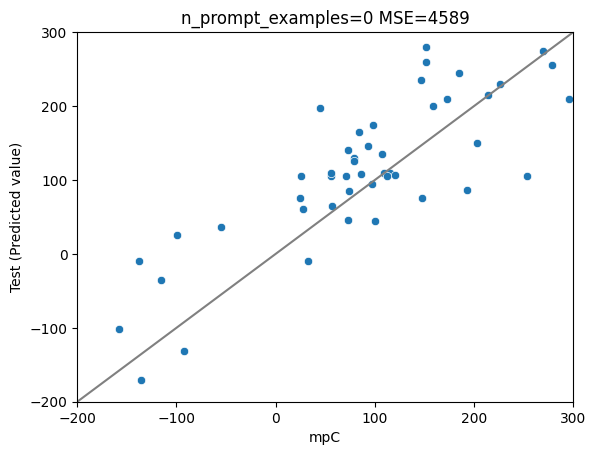

In [18]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [19]:
#スコア
print("MSE: ",mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("MAE: ",mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print("R2: ", r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


MSE:  4588.79914893617
MAE:  54.60851063829788
R2:  0.6083226627371107


In [20]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.94